# Прогнозирование конечных свойств новых материалов (композиционных материалов)

Композиционные материалы — это искусственно созданные материалы, состоящие из нескольких других с четкой границей между ними. Композиты обладают теми свойствами, которые не наблюдаются у компонентов по отдельности. При этом композиты являются монолитным материалом, т. е. компоненты материала неотделимы друг от друга без разрушения конструкции в целом. Яркий пример композита - железобетон. Бетон прекрасно сопротивляется сжатию, но плохо растяжению. Стальная арматура внутри бетона компенсирует его неспособность сопротивляться сжатию, формируя тем самым новые, уникальные свойства. Современные композиты изготавливаются из других материалов: полимеры, керамика, стеклянные и углеродные волокна, но данный принцип сохраняется. 

У такого подхода есть и недостаток: даже если мы знаем характеристики исходных компонентов, определить характеристики композита, состоящего из этих компонентов, достаточно проблематично. Для решения этой проблемы есть два пути: физические испытания образцов материалов, или прогнозирование характеристик. 

Суть прогнозирования заключается в симуляции представительного элемента объема композита, на основе данных о характеристиках входящих компонентов (связующего и армирующего компонента).

Кейс основан на реальных производственных задачах ООО «СК-СХД».

Актуальность: Созданные прогнозные модели помогут сократить количество проводимых испытаний, а также пополнить базу данных материалов возможными новыми характеристиками материалов, и цифровыми двойниками новых композитов.

### Цель:

спрогнозировать ряд конечных свойств получаемых композиционных материалов.

### Задача:

выбрать лучшую модель для определения конечных свойств композиционных материалов.


### Описание исходных данных:

Представлены данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.). 

Данные состоят из двух файлов: `X_bp.xlsx` и `X_nup.xlsx`.

## Загрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from flask import Flask
from keras import optimizers
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D

In [2]:
!pip freeze > requirements.txt

## 1. Обработка данных

In [3]:
df_bp = pd.read_excel('../data/X_bp.xls', index_col=0)

In [4]:
df_nup = pd.read_excel('../data/X_nup.xls', index_col=0)

In [5]:
df_bp.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,70.0,3000.0,220.0
1,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0
2,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,70.0,3000.0,220.0
3,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0
4,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0


In [6]:
df_nup.head()

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0,4.0,57.0
1,0,4.0,60.0
2,0,4.0,70.0
3,0,5.0,47.0
4,0,5.0,57.0


In [7]:
# переименуем столбцы в таблицах на локоничные названия латиницей

df_bp = df_bp.rename(columns={'Соотношение матрица-наполнитель': 'force_displacement_relation',
                              'Плотность, кг/м3': 'density',
                              'модуль упругости, ГПа': 'elasticity',
                              'Количество отвердителя, м.%': 'hardener',
                              'Содержание эпоксидных групп,%_2': 'epoxy',
                              'Температура вспышки, С_2': 'flash_point',
                              'Поверхностная плотность, г/м2': 'surface_density',
                              'Модуль упругости при растяжении, ГПа': 'tensile_modulus',
                              'Прочность при растяжении, МПа': 'tensile_strength',
                              'Потребление смолы, г/м2': 'rabber'})

df_nup = df_nup.rename(columns={'Угол нашивки, град': 'patch_incline',
                              'Шаг нашивки': 'patch_step',
                              'Плотность нашивки': 'patch_density'})

**Наименование столбцов в таблицах:**

- `force_displacement_relation` - cоотношение матрица-наполнитель,

- `density` - плотность, кг/м3,

- `elasticity` - модуль упругости, ГПа,

- `hardener` - количество отвердителя, м.%,

- `epoxy` - содержание эпоксидных групп,%_2,

- `flash_point` - температура вспышки, С_2,

- `surface_density` - поверхностная плотность, г/м2,

- `tensile_modulus` - модуль упругости при растяжении, ГПа,

- `tensile_strength` - прочность при растяжении, МПа,

- `rabber` - потребление смолы, г/м2



- `patch_incline` - угол нашивки, град,

- `patch_step` - шаг нашивки,
                              
- `patch_density` - плотность нашивки, ГПа

In [8]:
df_nup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 0 to 1039
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patch_incline  1040 non-null   int64  
 1   patch_step     1040 non-null   float64
 2   patch_density  1040 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 32.5 KB


In [9]:
df_bp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   force_displacement_relation  1023 non-null   float64
 1   density                      1023 non-null   float64
 2   elasticity                   1023 non-null   float64
 3   hardener                     1023 non-null   float64
 4   epoxy                        1023 non-null   float64
 5   flash_point                  1023 non-null   float64
 6   surface_density              1023 non-null   float64
 7   tensile_modulus              1023 non-null   float64
 8   tensile_strength             1023 non-null   float64
 9   rabber                       1023 non-null   float64
dtypes: float64(10)
memory usage: 87.9 KB


В данных отсутсвуют пропуски.

Таблицы имеют различное количество строк, но описывают одни и те же композитные материалы. Согласно условию задачи, можно объединить таблицы по индексу.

In [10]:
# объединим таблицы
df = df_bp.join(df_nup, how='inner')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   force_displacement_relation  1023 non-null   float64
 1   density                      1023 non-null   float64
 2   elasticity                   1023 non-null   float64
 3   hardener                     1023 non-null   float64
 4   epoxy                        1023 non-null   float64
 5   flash_point                  1023 non-null   float64
 6   surface_density              1023 non-null   float64
 7   tensile_modulus              1023 non-null   float64
 8   tensile_strength             1023 non-null   float64
 9   rabber                       1023 non-null   float64
 10  patch_incline                1023 non-null   int64  
 11  patch_step                   1023 non-null   float64
 12  patch_density                1023 non-null   float64
dtypes: float64(12), in

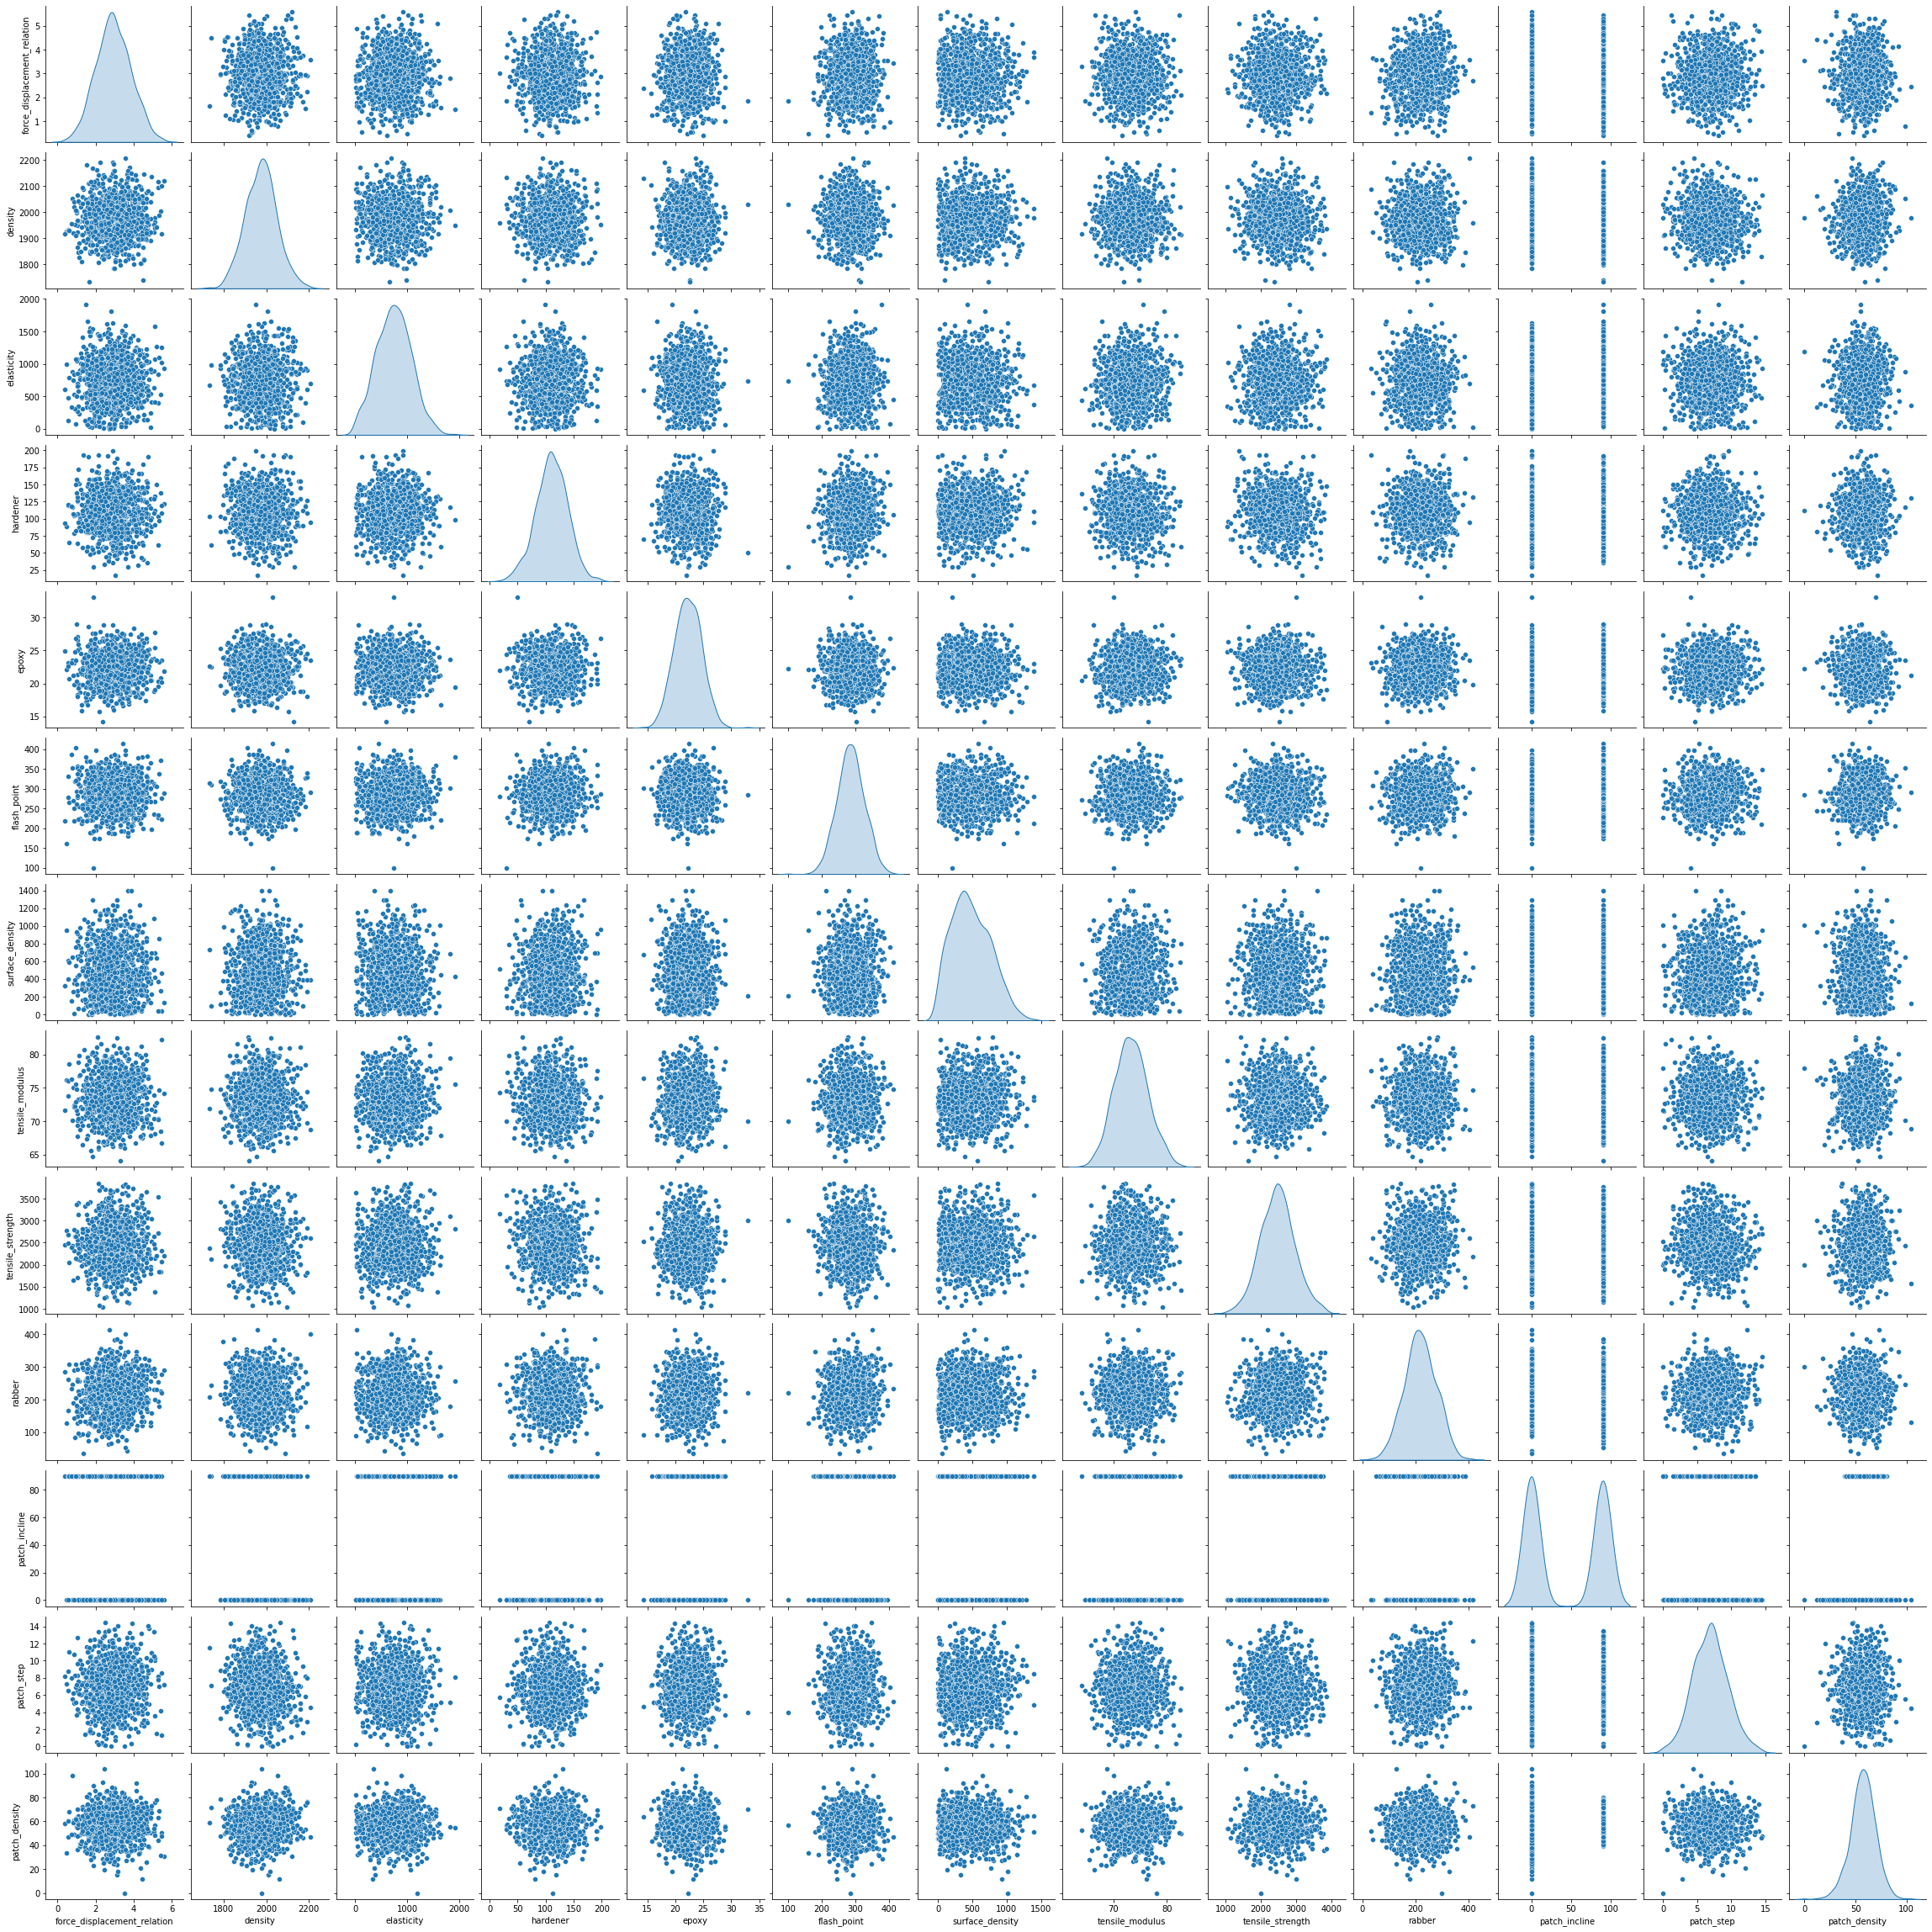

In [12]:
# рассмотрим кореляции между данными
sns.pairplot(df, diag_kind='kde')

В данных отсутсвуют пропуски, аномальные значения и дубликаты, в связи с чем дальнейшая обработка данных не требуется.

## 2. Определение целевых показателей и признаков

**В качестве целевых показателей определим:**

- `density` - плотность, кг/м3,

- `elasticity` - модуль упругости, ГПа,

- `surface_density` - поверхностная плотность, г/м2,

- `tensile_modulus` - модуль упругости при растяжении, ГПа,

- `tensile_strength` - прочность при растяжении, МПа,

**В качестве признаков определим остальные:**

- `force_displacement_relation` - cоотношение матрица-наполнитель,

- `hardener` - количество отвердителя, м.%,

- `epoxy` - содержание эпоксидных групп,%_2,

- `flash_point` - температура вспышки, С_2,

- `rabber` - потребление смолы, г/м2

- `patch_incline` - угол нашивки, град,

- `patch_step` - шаг нашивки,
                              
- `patch_density` - плотность нашивки, ГПа

In [13]:
# таблица всех целевых показателей
target = df.drop(['force_displacement_relation', 'hardener', 'epoxy', 'flash_point',
                  'rabber', 'patch_incline', 'patch_step', 'patch_density'], axis=1)

# таблицы цна каждый целевой показатель
target_1 = df['density']
target_2 = df['elasticity']
target_3 = df['surface_density']
target_4 = df['tensile_modulus']
target_5 = df['tensile_strength']

# таблица признаков
features = df.drop(['density', 'elasticity', 'surface_density', 'tensile_modulus', 'tensile_strength'], axis=1)

In [14]:
# масштабирование признаков

scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

## 3. Разделение данных на тренировочную, валидационную и тестовую выборки

In [15]:
# Разобъем данные на выборки 70/15/15
features_train, features_temp, target_train, target_temp = train_test_split(features, target, train_size=0.6, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, train_size=0.5, random_state=12345)

# проверим размеры воборки
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(613, 8)
(205, 8)
(205, 8)


In [16]:
# тренировочная выборка целевых показателей для каждого признака отдельно
target_train_1 = target_train['density']
target_train_2 = target_train['elasticity']
target_train_3 = target_train['surface_density']
target_train_4 = target_train['tensile_modulus']
target_train_5 = target_train['tensile_strength']

In [17]:
# валидационная выборка целевых показателей для каждого признака отдельно
target_valid_1 = target_valid['density']
target_valid_2 = target_valid['elasticity']
target_valid_3 = target_valid['surface_density']
target_valid_4 = target_valid['tensile_modulus']
target_valid_5 = target_valid['tensile_strength']

In [18]:
# тестовая выборка целевых показателей для каждого признака отдельно
target_test_1 = target_test['density']
target_test_2 = target_test['elasticity']
target_test_3 = target_test['surface_density']
target_test_4 = target_test['tensile_modulus']
target_test_5 = target_test['tensile_strength']

## 4. Моделирование

### 4.1 Модель линейной регрессии

In [19]:
# Напишем функцию определения метрики MAE для модели линейной регрессии

def mae_l (features_train, target_train, features_valid, target_valid):
    model_l = LinearRegression()
    model_l.fit(features_train, target_train)
    predictions = model_l.predict(features_valid)
    result = mean_squared_error(target_valid, predictions)**0.5
    return result

In [20]:
# метрика MAE для целевого показателя 1
mae_l_1 = mae_l(features_train, target_train_1, features_valid, target_valid_1)
print("MAE_1 модели линейной регрессии на валидационной выборке:", mae_l_1)

# метрика MAE для целевого показателя 1
mae_l_2 = mae_l(features_train, target_train_2, features_valid, target_valid_2)
print("MAE_2 модели линейной регрессии на валидационной выборке:", mae_l_2)

# метрика MAE для целевого показателя 3
mae_l_3 = mae_l(features_train, target_train_3, features_valid, target_valid_3)
print("MAE_3 модели линейной регрессии на валидационной выборке:", mae_l_3)

# метрика MAE для целевого показателя 4
mae_l_4 = mae_l(features_train, target_train_4, features_valid, target_valid_4)
print("MAE_4 модели линейной регрессии на валидационной выборке:", mae_l_4)

# метрика MAE для целевого показателя 5
mae_l_5 = mae_l(features_train, target_train_5, features_valid, target_valid_5)
print("MAE_5 модели линейной регрессии на валидационной выборке:", mae_l_5)

MAE_1 модели линейной регрессии на валидационной выборке: 77.87640736794798
MAE_2 модели линейной регрессии на валидационной выборке: 314.5460495013235
MAE_3 модели линейной регрессии на валидационной выборке: 278.8732486554384
MAE_4 модели линейной регрессии на валидационной выборке: 3.2845066596654897
MAE_5 модели линейной регрессии на валидационной выборке: 483.4398475974678


### 4.2 Модель регрессии случайный лес

In [21]:
# определим лучшие параметры для данной модели

model_f = RandomForestRegressor(random_state=12345)
parametrs = {
    'n_estimators': range (10, 60, 5),
    'max_features': [5],
    'max_depth': [4, 5, 6]
}

grid = GridSearchCV(model_f,parametrs,cv = 3)
grid = RandomizedSearchCV(model_f, parametrs, cv=5)
grid.fit(features_train, target_train)

grid.best_params_

{'n_estimators': 50, 'max_features': 5, 'max_depth': 4}

In [22]:
# Напишем функцию определения метрики MAE для модели случайного леса

def mae_f (features_train, target_train, features_valid, target_valid):
    model_f = RandomForestRegressor(n_estimators=55, random_state=12345, max_depth=6, max_features=5)
    model_f.fit(features_train, target_train)
    predictions = model_f.predict(features_valid)
    result = mean_squared_error(target_valid, predictions)**0.5
    return result

In [23]:
# метрика MAE для целевого показателя 1
mae_f_1 = mae_f(features_train, target_train_1, features_valid, target_valid_1)
print("MAE_1 модели случайного леса на валидационной выборке:", mae_f_1)

# метрика MAE для целевого показателя 1
mae_f_2 = mae_f(features_train, target_train_2, features_valid, target_valid_2)
print("MAE_2 модели случайного леса на валидационной выборке:", mae_f_2)

# метрика MAE для целевого показателя 3
mae_f_3 = mae_f(features_train, target_train_3, features_valid, target_valid_3)
print("MAE_3 модели случайного леса на валидационной выборке:", mae_f_3)

# метрика MAE для целевого показателя 4
mae_f_4 = mae_f(features_train, target_train_4, features_valid, target_valid_4)
print("MAE_4 модели случайного леса на валидационной выборке:", mae_f_4)

# метрика MAE для целевого показателя 5
mae_f_5 = mae_f(features_train, target_train_5, features_valid, target_valid_5)
print("MAE_5 модели случайного леса на валидационной выборке:", mae_f_5)

MAE_1 модели случайного леса на валидационной выборке: 78.0403091454703
MAE_2 модели случайного леса на валидационной выборке: 315.8502100870767
MAE_3 модели случайного леса на валидационной выборке: 288.27955493981756
MAE_4 модели случайного леса на валидационной выборке: 3.2821602336285283
MAE_5 модели случайного леса на валидационной выборке: 485.62269503970816


### 4.3 Модель градиентного бустинга

In [24]:
reg = LGBMRegressor(random_state=0)

params = {
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

grid = GridSearchCV(LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(features_train, target_train_2)

grid.best_params_

{'max_depth': 3, 'n_estimators': 50}

In [25]:
# Напишем функцию определения метрики MAE для модели случайного леса

def mae_gb (features_train, target_train, features_valid, target_valid):
    model_gb = LGBMRegressor(max_depth=3, n_estimators=50)
    model_gb.fit(features_train, target_train)
    predictions = model_gb.predict(features_valid)
    result = mean_squared_error(target_valid, predictions)**0.5
    return result

In [26]:
# метрика MAE для целевого показателя 1
mae_gb_1 = mae_gb(features_train, target_train_1, features_valid, target_valid_1)
print("MAE_1 модели градиентного бустинга на валидационной выборке:", mae_gb_1)

# метрика MAE для целевого показателя 1
mae_gb_2 = mae_gb(features_train, target_train_2, features_valid, target_valid_2)
print("MAE_2 модели градиентного бустинга на валидационной выборке:", mae_gb_2)

# метрика MAE для целевого показателя 3
mae_gb_3 = mae_gb(features_train, target_train_3, features_valid, target_valid_3)
print("MAE_3 модели градиентного бустинга на валидационной выборке:", mae_gb_3)

# метрика MAE для целевого показателя 4
mae_gb_4 = mae_gb(features_train, target_train_4, features_valid, target_valid_4)
print("MAE_4 модели градиентного бустинга на валидационной выборке:", mae_gb_4)

# метрика MAE для целевого показателя 5
mae_gb_5 = mae_gb(features_train, target_train_5, features_valid, target_valid_5)
print("MAE_5 модели градиентного бустинга на валидационной выборке:", mae_gb_5)

MAE_1 модели градиентного бустинга на валидационной выборке: 78.84379752702165
MAE_2 модели градиентного бустинга на валидационной выборке: 323.34531642868143
MAE_3 модели градиентного бустинга на валидационной выборке: 292.26979447713694
MAE_4 модели градиентного бустинга на валидационной выборке: 3.375312757326173
MAE_5 модели градиентного бустинга на валидационной выборке: 490.5048326830869


### 4.4 Модель нейронной сети

In [27]:
# Подберем структуру модели

model_ns = keras.models.Sequential()

model_ns.add(Dense(128, activation='relu'))
model_ns.add(Dense(64, activation='relu'))
model_ns.add(Dense(64, activation='relu'))
model_ns.add(Dense(32, activation='relu'))
model_ns.add(Dense(32, activation='relu'))
model_ns.add(Dense(16, activation='relu'))
model_ns.add(Dense(units = 1, activation='relu'))

optimizer = keras.optimizers.Adam(lr=0.0001)

model_ns.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

C:\Users\blino\anaconda3\envs\ds_practicum_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
# Напишем функцию определения метрики MAE для модели нейронной сети

def mae_n (features_train, target_train, features_valid, target_valid):
    model_n = model_ns.fit(
    features_train,
    target_train,
    epochs=500,
    verbose=0,
    validation_data=(features_valid, target_valid))
    result = model_n.history['val_mae'][-1]
    return result

In [29]:
# метрика MAE для целевого показателя 1
mae_n_1 = mae_n(features_train, target_train_1, features_valid, target_valid_1)

In [30]:
# метрика MAE для целевого показателя 2
mae_n_2 = mae_n(features_train, target_train_2, features_valid, target_valid_2)

In [31]:
# метрика MAE для целевого показателя 3
mae_n_3 = mae_n(features_train, target_train_3, features_valid, target_valid_3)

In [32]:
# метрика MAE для целевого показателя 4
mae_n_4 = mae_n(features_train, target_train_4, features_valid, target_valid_4)

In [33]:
# метрика MAE для целевого показателя 5
mae_n_5 = mae_n(features_train, target_train_5, features_valid, target_valid_5)

In [34]:
# метрика MAE для целевого показателя 1
print("MAE_1 модели нейронной сети на валидационной выборке:", mae_n_1)

# метрика MAE для целевого показателя 2
print("MAE_2 модели нейронной сети на валидационной выборке:", mae_n_2)

# метрика MAE для целевого показателя 3
print("MAE_3 модели нейронной сети на валидационной выборке:", mae_n_3)

# метрика MAE для целевого показателя 4
print("MAE_4 модели нейронной сети на валидационной выборке:", mae_n_4)

# метрика MAE для целевого показателя 5
print("MAE_5 модели нейронной сети на валидационной выборке:", mae_n_5)

MAE_1 модели нейронной сети на валидационной выборке: 69.96511840820312
MAE_2 модели нейронной сети на валидационной выборке: 253.94117736816406
MAE_3 модели нейронной сети на валидационной выборке: 241.53907775878906
MAE_4 модели нейронной сети на валидационной выборке: 2.8648154735565186
MAE_5 модели нейронной сети на валидационной выборке: 409.4089050292969


In [35]:
model_ns.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [36]:
# График изменения показателя потерь для показателя 1 для примера

def plot_loss(model_n):
    plt.figure(figsize=(15,6), dpi=80)
    plt.plot(model_n.history['mae'], label='mae')
    plt.plot(model_n.history['val_mae'], label='val_mae')
    plt.xlabel('Эпоха')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.title("График метрики MAE_1 для модели нейронной сети в зависимости от эпохи")
    
model_n_1 = model_ns.fit(
    features_train,
    target_train_1,
    epochs=500,
    verbose=0,
    validation_data=(features_valid, target_valid_1))

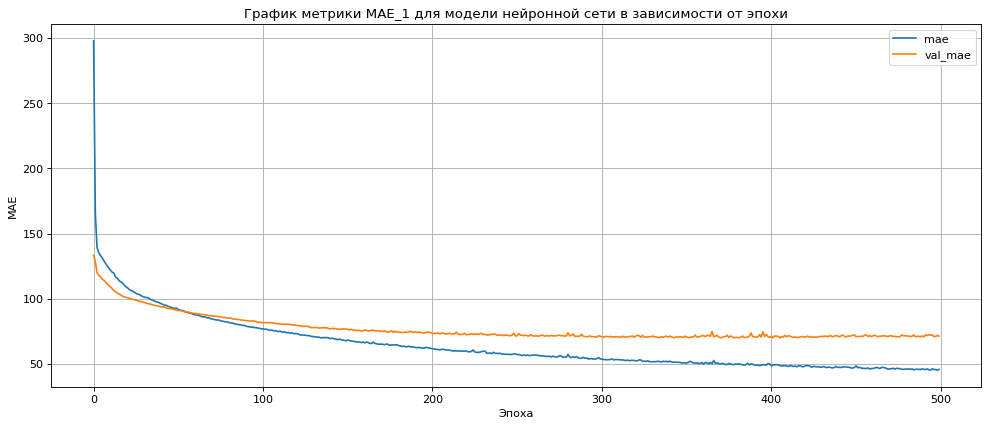

In [37]:
plot_loss(model_n_1)

### 4.5 Сравнение качества моделей

Рассмотрим сводную таблицу полученных метрик MAE рассмотренных моделей

In [38]:
# сформируем сводную таблицу метрик для каждой модели

models = ['LinearRegression', 'RandomForestClassifier', 'LGBMRegressor', 'KerasSequential']
mae_1 = [mae_l_1, mae_f_1, mae_gb_1, mae_n_1]
mae_2 = [mae_l_2, mae_f_2, mae_gb_2, mae_n_2]
mae_3 = [mae_l_3, mae_f_3, mae_gb_3, mae_n_3]
mae_4 = [mae_l_4, mae_f_4, mae_gb_4, mae_n_4]
mae_5 = [mae_l_5, mae_f_5, mae_gb_5, mae_n_5]

model_comp = pd.DataFrame({'model': models,'MAE_1': mae_1,'MAE_2': mae_2,'MAE_3': mae_3,'MAE_4': mae_4,'MAE_5': mae_5})
model_comp = model_comp.set_index('model')

In [39]:
model_comp

,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5
model,,,,,
LinearRegression,77.876407,314.546050,278.873249,3.284507,483.439848
RandomForestClassifier,78.040309,315.850210,288.279555,3.282160,485.622695
LGBMRegressor,78.843798,323.345316,292.269794,3.375313,490.504833
KerasSequential,69.965118,253.941177,241.539078,2.864815,409.408905


Text(0.5, 1.0, 'Тепловая карта отмасштабированных метрик MAE')

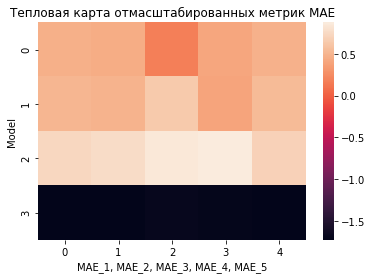

In [58]:
# Построим тепловую карту таблицы выше для метрик MAE на отмасштабированных данных
# с целью наглядно отобразить качество рассмотренных моделей

scaler = StandardScaler()
scaler.fit(model_comp)
model_comp_t = scaler.transform(model_comp)

sns.heatmap(model_comp_t)
plt.xlabel('MAE_1, MAE_2, MAE_3, MAE_4, MAE_5')
plt.ylabel('Model')
plt.title("Тепловая карта отмасштабированных метрик MAE")

**Вывод:**
Из рассмотренных моделей наиболее качественные результаты по метрикам MAE показала модель нейронной сети. Проверим качество модели на тестовой выборке. Однако, в ходе перезапусков программы обнаруживаются нестабильные метрики качества на таком количестве исходных данных для этой модели. 

На втором месте по показателям - модель линейной регрессии.
Далее протестируем модель нейронной сети и модель линейной регрессии.

## 5. Тестирование наилучших моделей

### 5.1 Тестирование модели нейронной сети

In [41]:
# Напишем функцию определения метрики MAE для модели нейронной сети

def mae_n (features_train, target_train, features_valid, target_valid):
    model_n = model_ns.fit(
    features_train,
    target_train,
    epochs=500,
    verbose=0,
    validation_data=(features_valid, target_valid))
    result = model_n.history['val_mae'][-1]
    return result

In [42]:
# метрика MAE для целевого показателя 1
mae_nt_1 = mae_n(features_train, target_train_1, features_test, target_test_1)

In [43]:
# метрика MAE для целевого показателя 2
mae_nt_2 = mae_n(features_train, target_train_2, features_test, target_test_2)

In [44]:
# метрика MAE для целевого показателя 3
mae_nt_3 = mae_n(features_train, target_train_3, features_test, target_test_3)

In [45]:
# метрика MAE для целевого показателя 4
mae_nt_4 = mae_n(features_train, target_train_4, features_test, target_test_4)

In [46]:
# метрика MAE для целевого показателя 5
mae_nt_5 = mae_n(features_train, target_train_5, features_test, target_test_5)

In [47]:
# метрика MAE для целевого показателя 1
print("MAE_1 модели нейронной сети на тестовой выборке:", mae_nt_1)

# метрика MAE для целевого показателя 2
print("MAE_2 модели нейронной сети на тестовой выборке:", mae_nt_2)

# метрика MAE для целевого показателя 3
print("MAE_3 модели нейронной сети на тестовой выборке:", mae_nt_3)

# метрика MAE для целевого показателя 4
print("MAE_4 модели нейронной сети на тестовой выборке:", mae_nt_4)

# метрика MAE для целевого показателя 5
print("MAE_5 модели нейронной сети на тестовой выборке:", mae_nt_5)

MAE_1 модели нейронной сети на тестовой выборке: 69.7217788696289
MAE_2 модели нейронной сети на тестовой выборке: 328.0758056640625
MAE_3 модели нейронной сети на тестовой выборке: 286.8528137207031
MAE_4 модели нейронной сети на тестовой выборке: 3.683856248855591
MAE_5 модели нейронной сети на тестовой выборке: 510.6617126464844


In [48]:
# сформируем сводную таблицу

models = ['valid', 'test']
mae_1 = [mae_n_1, mae_nt_1]
mae_2 = [mae_n_2, mae_nt_2]
mae_3 = [mae_n_3, mae_nt_3]
mae_4 = [mae_n_4, mae_nt_4]
mae_5 = [mae_n_5, mae_nt_5]

model_comp_t = pd.DataFrame({'model': models,'MAE_1': mae_1,'MAE_2': mae_2,'MAE_3': mae_3,'MAE_4': mae_4,'MAE_5': mae_5})
model_comp_t = model_comp_t.set_index('model')

In [49]:
model_comp_t

,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5
model,,,,,
valid,69.965118,253.941177,241.539078,2.864815,409.408905
test,69.721779,328.075806,286.852814,3.683856,510.661713


На тесте модель нейронной сети показывает результаты хуже, чем на валидационной выборке

### 5.2 Тестирование модели линейной регрессии

In [50]:
# метрика MAE для целевого показателя 1
mae_lt_1 = mae_l(features_train, target_train_1, features_test, target_test_1)
print("MAE_1 модели линейной регрессии на тестовой выборке:", mae_lt_1)

# метрика MAE для целевого показателя 1
mae_lt_2 = mae_l(features_train, target_train_2, features_test, target_test_2)
print("MAE_2 модели линейной регрессии на тестовой выборке:", mae_lt_2)

# метрика MAE для целевого показателя 3
mae_lt_3 = mae_l(features_train, target_train_3, features_test, target_test_3)
print("MAE_3 модели линейной регрессии на тестовой выборке:", mae_lt_3)

# метрика MAE для целевого показателя 4
mae_lt_4 = mae_l(features_train, target_train_4, features_test, target_test_4)
print("MAE_4 модели линейной регрессии на тестовой выборке:", mae_lt_4)

# метрика MAE для целевого показателя 5
mae_lt_5 = mae_l(features_train, target_train_5, features_test, target_test_5)
print("MAE_5 модели линейной регрессии на тестовой выборке:", mae_lt_5)

MAE_1 модели линейной регрессии на тестовой выборке: 77.89729953151347
MAE_2 модели линейной регрессии на тестовой выборке: 336.5312982402963
MAE_3 модели линейной регрессии на тестовой выборке: 269.63106913791256
MAE_4 модели линейной регрессии на тестовой выборке: 3.2725305379203875
MAE_5 модели линейной регрессии на тестовой выборке: 490.1300212176131


In [51]:
# сформируем сводную таблицу

models = ['valid', 'test']
mae_1 = [mae_l_1, mae_lt_1]
mae_2 = [mae_l_2, mae_lt_2]
mae_3 = [mae_l_3, mae_lt_3]
mae_4 = [mae_l_4, mae_lt_4]
mae_5 = [mae_l_5, mae_lt_5]

model_comp_lt = pd.DataFrame({'model': models,'MAE_1': mae_1,'MAE_2': mae_2,'MAE_3': mae_3,'MAE_4': mae_4,'MAE_5': mae_5})
model_comp_lt = model_comp_lt.set_index('model')

In [52]:
model_comp_lt

,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5
model,,,,,
valid,77.876407,314.546050,278.873249,3.284507,483.439848
test,77.897300,336.531298,269.631069,3.272531,490.130021


На тесте модель линейной регрессии показывает лучшие результаты, чем на валидационной выборке.

### 5.3 Сравнение работы моделей линейной регрессии и нейронной сети на тестовой выборке.

In [53]:
# сформируем сводную таблицу, чтобы сравнить работу моделей линейной регресии и нейронной сети на тестовой выборке

models = ['LinearRegression', 'KerasSequential']
mae_1 = [mae_lt_1, mae_nt_1]
mae_2 = [mae_lt_2, mae_nt_2]
mae_3 = [mae_lt_3, mae_nt_3]
mae_4 = [mae_lt_4, mae_nt_4]
mae_5 = [mae_lt_5, mae_nt_5]

model_comp_t = pd.DataFrame({'model': models,'MAE_1': mae_1,'MAE_2': mae_2,'MAE_3': mae_3,'MAE_4': mae_4,'MAE_5': mae_5})
model_comp_t = model_comp_t.set_index('model')

In [54]:
model_comp_t

,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5
model,,,,,
LinearRegression,77.897300,336.531298,269.631069,3.272531,490.130021
KerasSequential,69.721779,328.075806,286.852814,3.683856,510.661713


### 5.4 Вывод:
На тесте модель линейной регрессии показывает значительно лучшие результаты, чем модель нейронной сети на тестовой выборке.

Модель нейронной сети на таком количестве данных показывает нестабильную работу.

В связи с описанным выше, можно сделать вывод о том, что в работу следует принимать модель линейной регрессии.

## 6. Выводы:


С целью прогнозирования пяти характеристик будущего композитного материала на основе его составляющих и методов формирования были рассмотрены 4 модели: модель линейной регерссии, случайного леса, градиентного бустинга и нейронной сети.

В ходе рассмотрения наиболее точной себя проявила модель нйронной сети, однако на таком объеме данных она работает нестабильно и не каждый раз дает точные предстказания. 

Следующая по точности себя проявила модель линейной регрессии. К тому же, при проверке на тестовой выборке модель линейной регрессии показывает значительно лучшие результаты, чем модель нейронной сети.

В связи с описанным выше, можно сделать вывод о том, что в работу следует принимать модель линейной регрессии.

В связи с чем, далее рассмотрим разработку приложения для решения поставленной задачи с применением модели линейной регрессии.